# Algorithms in Machine Learning
## Student: Javier CUADRADO ANÍBARRO

The present notebook can be also found in https://github.com/J-Cuadrado/AML_Evaluation

# Prerequisites

Please run the following line of code if the packages are not already installed in your computer, or if you are running this notebook on Google Colab.

In [1]:
# !pip install numpy sklearn torch torchvision matplotlib seaborn tqdm

<div class="alert alert-block alert-warning"><b>Advice:</b> 
    
Due to the amount of time stochastic algorithms can take, as well of the time involved in training a neural network, we suggest completely launching the notebook since the beginning, and gradually explore its content while the code is running..</div>

# Introduction

The aim of this notebook is to present the possible advantages of multidimensional genetic programming for multiclass classification, comparing it to other most common classification methods such as neural networks. The source article for this notebook can be found in the following link:

https://www.sciencedirect.com/science/article/pii/S2210650217309136

The main goal of this article is to present a method for feature selection and construction, which ara key componenst to classification problems in machine learning. Notably, we want to exploit the intrinsic characteristics of genetic programming, which implicitly performs feature selection and construction over the data, while also making fewer _a priori_ assumptions on the data. Let us quote the article to clarify this point in a more rigorous way:

_"A well known learning method that implicitly conducts feature selection and construction is genetic programming (GP), which has been proposed for classification. GP incorporates feature selection and construction by optimizing a population of programs constructed from a set of instructions that operate on the dataset features to produce a model. Compared to traditional ML approaches such as logistic regression and decision tree classification, GP makes fewer a priori assumptions about the data [...]"_

So, in short, we want to exploit the fact that GP algorithms can find hidden interactions among the data, to best summarize it and help the classification.

We will begin by presenting the data we will use to perform the classifications, and then show the advantages and disadvantages of such an approach. Next, we will compare our simple implementation with the more advanced solutions proposed in the article. Finally, we will explore some potential applications of the algorithm presented in the paper.

# Data generation

We are going to begin by creating the data with which we will work. Our data will consist of a set of $\mathbb{R}^4$ points obtained the following way:

$$\left\{\begin{array}{ll} x_1 \cdot x_3 - x_2 \cdot x_4 & = A \\ x_1 \cdot x_4 - x_2 \cdot x_3 & = B\end{array}\right.$$

Of course, the generation of the poins will be noisy, so the relationship between the values will not exactly add A or B, but something in between.

In [2]:
import numpy as np

In [3]:
def generate_point(A,B,attenuation=10):
    """
    Variables: 
    A, B: real numbers
    attenuation: dividing factor used when adding noise from a N(0,1) distribution
    
    Output:
    [x1, x2, x3, x4]: numpy ndarray of real values
    
    Definition:
    This function generates a point [x1, x2, x3, x4] so that:
    x1, x2 are randomly drawn from a uniform distribution [-5, 5]
    x3, x4 satisfy the conditions:
        x1*x3 - x2*x4 = A
        x1*x4 - x2*x3 = B
    Finally, a random noise is added to each one of the four values. The noise is drawn
    from a N(0,1) distribution, and divided by the attenuation factor (effectively
    modifying the standard deviation)    
    """
    
    x1 = np.random.uniform(-5,5)
    x2 = np.random.uniform(-5,5)
    x3 = (x1*A+x2*B)/(x1**2+x2**2)
    x4 = (x1*B-x2*A)/(x1**2+x2**2)
    x = [x1, x2, x3, x4] + np.random.randn(1,4)/attenuation
    x = np.float32(x)
    return x[0,:]

In [4]:
def decode(x):
    """
    The sole goal of this function is to verify the correct behavior of the data generation function    
    """
    A = x[0]*x[2]-x[1]*x[3]
    B = x[0]*x[3]+x[1]*x[2]
    return [A, B]

In [5]:
# We generate a test point:
x_test = generate_point(5,5)
print(f"Test point: {x_test}")

Test point: [ 0.76028126  0.9490855   5.765609   -0.37805218]


In [6]:
# We verify that the decoded point is similar to (5,5)
print(f"Decoded point: {decode(x_test)}")

Decoded point: [4.742288, 5.1846294]


Once the functions to generate the data have been defined, we proceed to create three shuffled datasets: training (400 points), validation ( 200 points) and test (100 points). We will generate four clusters in each of the datasets: one with points centered around (0,0), another one of points generated around (0,5), a third one of points generated around (5,0), and a final one of points centered around (5,5).

In [7]:
from sklearn.utils import shuffle

def generate_data(points_per_cat):
    """
    Input:
    points_per_cat: integer, number of points in each cluster of the dataset
   
    Output:
    X: dataset
    y: labels
    """
    X = np.zeros((4*points_per_cat,4))
    y = np.zeros((4*points_per_cat,1))

    for i in range(points_per_cat):
        X[i,:] = generate_point(0,0)
        y[i,:] = 0
    
    for i in range(points_per_cat, 2*points_per_cat):
        X[i,:] = generate_point(0,5)
        y[i,:] = 1

    for i in range(2*points_per_cat, 3*points_per_cat):    
        X[i,:] = generate_point(5,0)
        y[i,:] = 2

    for i in range(3*points_per_cat, 4*points_per_cat):
        X[i,:] = generate_point(5,5)
        y[i,:] = 3
    
    X, y = shuffle(X, y)
    
    return X, y

# Training set
X, y = generate_data(100)
# Validation set
Xval, yval = generate_data(50)
# Test set
Xtest, ytest = generate_data(25)

Let us take a closer look on some of the data (fist ten points of the suffled training dataset)

In [8]:
for i in range(10):
    print(f"Point #{i}: Values {X[i,:]}, Label {y[i][0]}")

Point #0: Values [-0.49593532 -2.26538801 -1.87913263 -0.58427697], Label 1.0
Point #1: Values [-1.47253633  3.89653206 -0.4279336  -0.92480159], Label 2.0
Point #2: Values [3.64160395 0.10334127 1.29061282 1.1977613 ], Label 3.0
Point #3: Values [4.78051567 1.84801495 0.60152858 0.88286597], Label 1.0
Point #4: Values [1.40424967 0.52826703 4.34289312 2.28075385], Label 3.0
Point #5: Values [-4.74999666e+00  2.65555292e-01 -1.00839412e+00 -3.31999292e-03], Label 2.0
Point #6: Values [-0.28829813  3.33859038  0.01084983  0.03876285], Label 0.0
Point #7: Values [3.76382208 0.95562071 0.30729774 1.17207432], Label 1.0
Point #8: Values [-0.78158349 -3.70033884 -1.56201923  1.10074151], Label 3.0
Point #9: Values [-1.49903357  1.65310097  1.40301836 -1.59041488], Label 1.0


<div class="alert alert-block alert-danger"> <b>Obs.-</b> It is clear that no conclusions can be extracted at first glance from the dataset as far as the predicted labels: a performing algorithm is needed to classify these data.</div>


## Data to tensor

Our first impulse is to run the data through a neural network to see if we can classify it. To build the neural networks, we will be using Pytorch. In order to work with Pytorch, we need to convert our numpy arrays into pytorch tensors.

In [9]:
import torch
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def data_to_tensor(X,y):
    """
    Inputs:
    X, y: numpy arrays
    
    Output:
    X_tensor, y_tensor: pytorch tensors containing the same information as the input arrays
    """
    
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).long()
    
    return X_tensor, y_tensor

X_tensor, y_tensor = data_to_tensor(X,y)
Xval_tensor, yval_tensor = data_to_tensor(Xval, yval)
Xtest_tensor, ytest_tensor = data_to_tensor(Xtest, ytest)


# Neural network on raw data

## Architecture 

We proceed now to the classification of the generated data with our neural network. We have defined a 3-hidden-layer architecture, each of the hidden layers with 10 neurons and a ReLU activation.

- Since the interactions beween the data are fairly simple, we have decided to limit our neural network to a rather small architecture, in an effort to try to avoid overfitting of the values.
- Several activations were tested during the development of this code, and notable efforts were dedicated towards making the algorithm work with sigmoid functions. However, ReLU activation has proven to be the most performing activation  to meet our goals, so it has been chosen as our activation i the hidden layers.
- Poits are classed according to the output neuron which yields the higher value among the possible four categories.

In [11]:
from torch import nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, input_neurons = 4):
        super(SimpleNet, self).__init__()
        self.input_neurons = input_neurons
        self.fc1 = nn.Linear(self.input_neurons, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1, self.input_neurons)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x
    
net = SimpleNet()

## Training

For the training of the NN, we will use a batch size of 20 both for the training and the validation sets. Furthermore, a maximum of 50 epochs will be allowed, with an ealy stopping patience of 5 epochs.

In [12]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [13]:
def validation(net, Xval_tensor, yval_tensor):
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            inputs = Xval_tensor[data, :]
            labels = yval_tensor[data, :].resize(20)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    return valid_loss

def train(net,X_tensor, y_tensor, X_validation, y_validation, earlystopping=True):
#     optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    optimizer = torch.optim.Adam(net.parameters())
    train_history = []
    valid_history = []
    estop = EarlyStopping(patience=5)
    for epoch in range(50):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = X_tensor[data, :]
            labels = y_tensor[data, :].resize(20)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss = validation(net, X_validation, y_validation)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f' % (epoch, train_loss, valid_loss))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history

In [14]:
def plot_train_val(train, valid):
    """
    """
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel('Training', color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation', color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 00: train loss 28.02162, validation loss 13.92228
Epoch 01: train loss 27.81889, validation loss 13.84698
Epoch 02: train loss 27.65173, validation loss 13.78374
Epoch 03: train loss 27.49412, validation loss 13.72161
Epoch 04: train loss 27.32790, validation loss 13.65145
Epoch 05: train loss 27.15480, validation loss 13.57427
Epoch 06: train loss 26.93687, validation loss 13.50013
Epoch 07: train loss 26.71555, validation loss 13.39953
Epoch 08: train loss 26.41959, validation loss 13.27559
Epoch 09: train loss 26.10356, validation loss 13.12600
Epoch 10: train loss 25.73686, validation loss 12.96104
Epoch 11: train loss 25.30886, validation loss 12.79033
Epoch 12: train loss 24.88594, validation loss 12.58519
Epoch 13: train loss 24.42577, validation loss 12.40041
Epoch 14: train loss 23.95077, validation loss 12.20674
Epoch 15: train loss 23.46574, validation loss 11.98302
Epoch 16: train loss 22.97279, validation loss 11.79444
Epoch 17: train loss 22.45473, validation loss 1

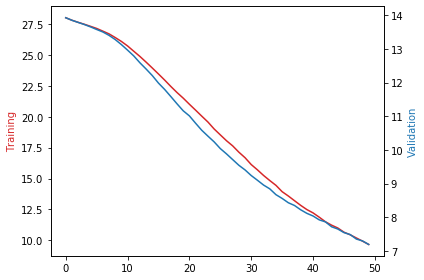

In [15]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet()
train_history, valid_history = train(net, X_tensor, y_tensor, Xval_tensor, yval_tensor)
plot_train_val(train_history, valid_history)

Confusion matrix


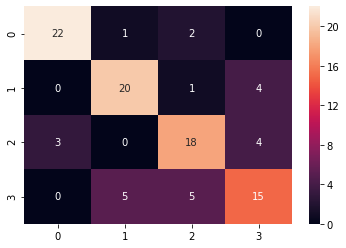

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
outputs = net(Xtest_tensor)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)

We can see that our NN is reasonably accurate. The discrepancies between the true data and the predicted values come from the noise introduced in data generation (lower noise yields higher accuracies), as well as the low number of epochs. However, a longer training may lead to overfitting, since the neural network may simply end up by learning the noise as a value, a detrimental feature for our intended goal.

# Neural network on transformed data

We proceed now to perform the same analysis on the decoded dataset

In [17]:
X_decoded = torch.zeros([400, 2], dtype=torch.float)
for i in range(400):
    X_decoded[i,:] = torch.FloatTensor(decode(X_tensor[i,:]))
    
Xval_decoded = torch.zeros([200, 2], dtype=torch.float)
for i in range(200):
    Xval_decoded[i,:] = torch.FloatTensor(decode(Xval_tensor[i,:]))
    
Xtest_decoded = torch.zeros([100, 2], dtype=torch.float)
for i in range(100):
    Xtest_decoded[i,:] = torch.FloatTensor(decode(Xtest_tensor[i,:]))

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 00: train loss 28.58169, validation loss 13.97417
Epoch 01: train loss 27.45688, validation loss 13.36809
Epoch 02: train loss 26.15980, validation loss 12.61766
Epoch 03: train loss 24.38707, validation loss 11.51508
Epoch 04: train loss 21.73256, validation loss 9.87780
Epoch 05: train loss 18.05457, validation loss 7.82263
Epoch 06: train loss 13.80671, validation loss 5.68808
Epoch 07: train loss 9.83596, validation loss 3.92342
Epoch 08: train loss 6.75925, validation loss 2.65723
Epoch 09: train loss 4.57862, validation loss 1.77512
Epoch 10: train loss 3.09749, validation loss 1.21046
Epoch 11: train loss 2.16325, validation loss 0.86114
Epoch 12: train loss 1.59393, validation loss 0.64026
Epoch 13: train loss 1.22606, validation loss 0.50605
Epoch 14: train loss 0.99009, validation loss 0.41654
Epoch 15: train loss 0.82499, validation loss 0.34647
Epoch 16: train loss 0.71363, validation loss 0.30821
Epoch 17: train loss 0.63958, validation loss 0.27000
Epoch 18: train l

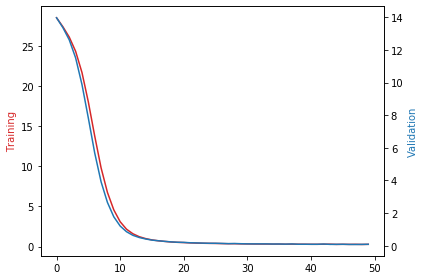

In [18]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet(input_neurons = 2)
train_history, valid_history = train(net, X_decoded, y_tensor, Xval_decoded, yval_tensor)
plot_train_val(train_history, valid_history)

Confusion matrix


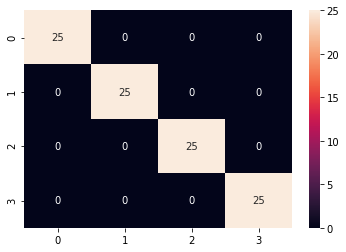

In [19]:
y_pred = []
outputs = net(Xtest_decoded)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)

As expected, the decoded dataset perfoms better than the raw one, being able to mitigate the noise influence on the classification. However, we have cheated on this analysis, since we knew the decoding algorithm prior to making the data classification. In real life, the data decoding may not be known, so we should be able to find a way to learn it.

# Genetic Programming

In [20]:
import random

x = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
data_len = x.shape[1]

def program_generator(data_len):
    program_len = random.randint(2,20)
    
    program = []
    
    
    values = [i for i in range(data_len)]
    
    program.append(random.choice(values))
    program.append(random.choice(values))

    values.append('+')
    values.append('-')
    values.append('*')
    values.append('/')
    
    for i in range(2,program_len):
        program.append(random.choice(values))
    
    return program

program = program_generator(data_len)
print(program)   



[2, 4, '/', 4, 4, 0, '-', 3]


program = $[0, 2, '*', 1, 3, '*', '-', 0, 3, '*', 1, 2, '*', '+']$

In [21]:
def program_reader(program, x):
    output = []
    for ele in program:
        if type(ele) == int:
            output.append(x[:,ele])
        else:
            try:
                b = output.pop()
                a = output.pop()
                if ele == '+':
                    output.append(a+b)
                elif ele == '-':
                    output.append(a-b)
                elif ele == '*':
                    output.append(a*b)
                elif ele == '/' and b != 0:
                    output.append(a/b)
                else:
                    raise
            except:
                output = 'Error'
                break
           
    if output == 'Error':
        outmat = 'Error'
    else:
        newdim = len(output)
    
        outmat = np.zeros((x.shape[0],newdim))
        for ele in range(newdim):
            outmat[:,ele] = output[ele]
        
    return outmat 

In [22]:
population_size = 50
population = []
errors = []

x = np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])

for i in range(population_size):
    population.append(program_generator(data_len))

In [23]:
output = []
for i in range(population_size):
    output.append(program_reader(population[i], x))
    if type(output[-1]) == str:
        errors.append(i)

errors.reverse()        

for err in errors:
    output.pop(err)
    population.pop(err)

In [24]:
population

[[2, 0, 4],
 [2, 0, 3, 0, '*', '+', 2, '-', 3],
 [3, 1, 4, '+', 1, 0, 3, '*', '-', 2, 1],
 [2, 3, '*'],
 [0, 2],
 [0, 4, 1],
 [4, 0, 0, 2, '-', 1, '+', 3],
 [0, 0],
 [3, 3, 0, 2, 4, 3, '+', 3, '-', 1],
 [3, 2, 2, 3, 3, 0, 0, 3, 3, '-', '-'],
 [2, 4, 0, 0, 3],
 [1, 2, '+'],
 [2, 3],
 [0, 3, 0, 0, 1, '+', 4],
 [2, 2, '-'],
 [3, 2, 0, 0, 3, 2, 1, 1, '*', 4, '*'],
 [4, 2, 1, '-', 2, 0, '*', 0, 0, 0, 3, 4],
 [0, 1, 0, 3, '+', 2, 0, 4, '+']]

In [25]:
from sklearn.neighbors import NearestCentroid
from tqdm import tqdm

max_generations = 5000
population_size = 500
population = []
y = y.reshape((400,))

stall = 0
max_stall = 500
last_best = []

for gen in tqdm(range(max_generations)):
    
    while len(population) > 0.5*population_size:
        population.pop()
    
    for ind in range(len(population), population_size):
        population.append(program_generator(X.shape[1]))
        
    output = []
    errors = []
    for i in range(population_size):
        output.append(program_reader(population[i], X))
        if type(output[-1]) == str:
            errors.append(i)

    errors.reverse()        

    for err in errors:
        output.pop(err)
        population.pop(err)
        
    score = []
    for i in range(len(output)):
        clf = NearestCentroid()
        clf.fit(output[i], y)
#         y_pred = clf.predict(output[i])
        score.append(clf.score(output[i],y))
    
    keys = sorted(range(len(score)), key=lambda k: score[k])
    keys.reverse()
    
    population_ordered = []
    for k in keys:
        population_ordered.append(population[k])
    population = population_ordered
    
    if population[0] == last_best:
        stall += 1 
        if stall == max_stall:
            print("Reached max. number of stall generations")
            break
    else:
        last_best = population[0]
        stall = 0
    
print(population[0])

 16%|████████████▉                                                                  | 819/5000 [02:36<13:21,  5.22it/s]

Reached max. number of stall generations
[2, 0, '*', 3, 3, 1, 0, '-', '*', 1, 3, 1, '+', 2, '*', 2]


Confusion matrix


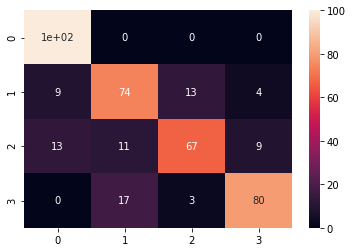

In [26]:
program = population[0]
X_trans = program_reader(program, X)
clf = NearestCentroid()
clf.fit(X_trans, y)
y_pred = clf.predict(X_trans)
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(cf_matrix, annot=True)

Confusion matrix


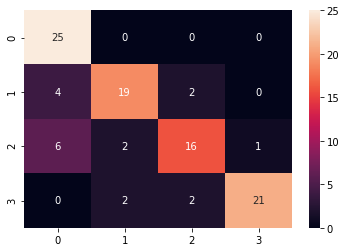

In [27]:
Xtest_trans = program_reader(program, Xtest)
ytest = ytest.reshape((100,))
ytest_pred = clf.predict(Xtest_trans)
print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, ytest_pred)
sns.heatmap(cf_matrix, annot=True)

Seeing these results, we may think that this classifier is worse than our neural network, but we must bear in mind that the NN was developped on the converted data. In order to compare the efficacity of the GA, we will run the transformed data over a NN, and see its performance.

In [28]:
transformation = population[0]

In [29]:
X_decoded2 = X_trans
Xval_decoded2 = program_reader(transformation, Xval)
Xtest_decoded2 = program_reader(transformation, Xtest)

In [30]:
X_decoded2_tensor, _ = data_to_tensor(X_decoded2,y)
Xval_decoded2_tensor, _ = data_to_tensor(Xval_decoded2, yval)
Xtest_decoded2_tensor, _ = data_to_tensor(Xtest_decoded2, ytest)

C:\Users\javie\anaconda3\lib\site-packages\torch\tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 00: train loss 27.80393, validation loss 13.80192
Epoch 01: train loss 27.38956, validation loss 13.61105
Epoch 02: train loss 26.99187, validation loss 13.37485
Epoch 03: train loss 26.41528, validation loss 13.04593
Epoch 04: train loss 25.67638, validation loss 12.59918
Epoch 05: train loss 24.82003, validation loss 12.14346
Epoch 06: train loss 23.96524, validation loss 11.71334
Epoch 07: train loss 23.24997, validation loss 11.31393
Epoch 08: train loss 22.58366, validation loss 10.99001
Epoch 09: train loss 21.97510, validation loss 10.63140
Epoch 10: train loss 21.33922, validation loss 10.31182
Epoch 11: train loss 20.67721, validation loss 9.97402
Epoch 12: train loss 20.03001, validation loss 9.65738
Epoch 13: train loss 19.27139, validation loss 9.26160
Epoch 14: train loss 18.50778, validation loss 8.83982
Epoch 15: train loss 17.64280, validation loss 8.46278
Epoch 16: train loss 16.75967, validation loss 8.04742
Epoch 17: train loss 15.82801, validation loss 7.64614

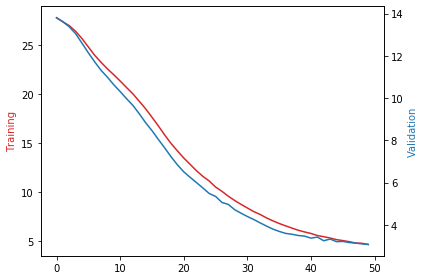

In [31]:
trainloader = torch.utils.data.DataLoader(range(400), batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
criterion = nn.CrossEntropyLoss()
net = SimpleNet(input_neurons = X_decoded2.shape[1])
train_history, valid_history = train(net, X_decoded2_tensor, y_tensor, Xval_decoded2_tensor, yval_tensor)
plot_train_val(train_history, valid_history)

Confusion matrix


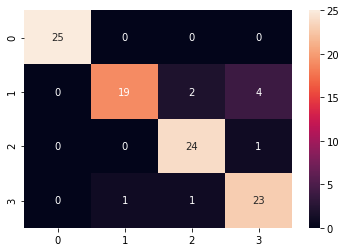

In [32]:
y_pred = []
outputs = net(Xtest_decoded2_tensor)
for i in range(100):
    y_pred.append(np.argmax(outputs[i,:].detach().numpy()))

print("Confusion matrix")
cf_matrix = confusion_matrix(ytest, y_pred)
sns.heatmap(cf_matrix, annot=True)

We can easily see that we have improved the accuracy over the first NN classification

In [33]:
# from sklearn.neural_network import MLPClassifier

# y_onehot_array = y_onehot.numpy()
# y_onehot_array

# myNN = MLPClassifier(hidden_layer_sizes=(8,16,8))
# myNN.fit(X, y_onehot_array)

In [34]:
# trainloader = torch.utils.data.DataLoader(range(200), batch_size=20, shuffle=True, num_workers=2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# train_loss = 0.0
# for i, data in enumerate(trainloader, 0):
#     # get the inputs; data is a list of [inputs, labels]
#     inputs = X_tensor[data, :]
#     print(inputs)
#     labels = y_tensor[data, :].resize(20)
#     print(labels)
#     # zero the parameter gradients
#     optimizer.zero_grad()
#     # forward + backward + optimize
#     outputs = net(inputs)
#     print(outputs)
#     loss = criterion(outputs, labels)
#     print(loss)
#     print(type(loss))
#     loss.backward()
#     optimizer.step()
#     train_loss += loss.item()